In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import os
#Hack to fix missing PROJ4 env var
import conda
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap, cm

In [2]:
%cd ~
sample = '/home/kinoshita/synthetic/bin/Z__C_RJTD_20170611173000_RDR_JMAGPV_Ggis1km_Prr10lv_ANAL_grib2.bin'
!wgrib2 $sample -order we:ns -V
!wgrib2 $sample -order we:ns -no_header -bin ~/out.bin

/home/kinoshita
1:0:vt=2017061117:surface:-10-0 min acc fcst:var discipline=0 center=34 local_table=1 parmcat=1 parm=201:
    ndata=8601600:undef=6248437:mean=0.0318277:min=0:max=107.5
    grid_template=0:winds(N/S):
	lat-lon grid:(2560 x 3360) units 1e-06 input WE:NS output WE:NS res 48
	lat 47.995833 to 20.004167 by 0.008333
	lon 118.006250 to 149.993750 by 0.012500 #points=8601600

** Warning: reference time includes non-zero minutes/seconds **
1:0:d=2017061117:var discipline=0 center=34 local_table=1 parmcat=1 parm=201:surface:-10-0 min acc fcst:


In [5]:
def convert_rep_to_level(intensity):
    '''
    https://www.data.jma.go.jp/add/suishin/catalogue/format/ObdObs001_format.pdf
    ※3 1kmメッシュ気象庁レーダー全国合成のレベル値(0~251)に沿って変換する
    '''
    intensity_level = np.zeros_like(intensity)
    intensity_level[intensity==9.999e+20] = 0  # レーダー外の値
    intensity_level[intensity==0.1] = 0
    intensity_level[intensity==260] = 256

    step_list = [0.1, 0.25, 0.5, 1.0, 2]
    block_first = [0.25, 2.13, 5.25, 10.5, 181]
    data_num = [18, 12, 10, 170, 38]

    for i, step in enumerate(step_list):
        rep = block_first[i] - step
        for i in list(range(data_num[i])):
            rep = round(rep + step, 2)
            mmh = round((rep*2-step)/2, 2)
            #print(rep, mmh)
            intensity_level[intensity==rep] = mmh
            
    return intensity_level

In [6]:
# 読み込み
f = open('/home/kinoshita/out.bin', mode='rb')
intensity = np.fromfile(f, dtype='float32',sep='').reshape(3360,2560)

In [7]:
intensity_level = convert_rep_to_level(intensity)

In [10]:
intensity=intensity_level

33.325 29.333333333333332 128.35 132.3375


/home/kinoshita/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'tri'
  s)


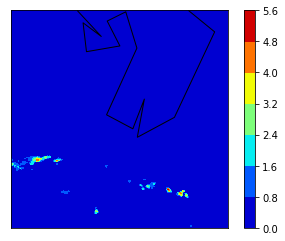

In [11]:
# 緯度経度の設定
grid_shape = (3360,2560)
lat_step = (48-20) / grid_shape[0]
lon_step = (150-118) / grid_shape[1]

lats = np.zeros((grid_shape[0],1))
lons = np.zeros((1,grid_shape[1]))

for i in list(range(grid_shape[0])):
    lats[i][0] = 48 - i*lat_step
for i in list(range(grid_shape[1])):
    lons[0][i] = 118 + i*lon_step

lats = np.tile(lats, (1,grid_shape[1]))
lons = np.tile(lons, (grid_shape[0],1))

# 座標を指定，その周辺を切り取る
city = (31.33, 130.34)
#city=(35,140)
#city=(36,135)
d = 2

n = np.where(lats[:,0]<city[0]+d)[0][0]
s = np.where(city[0]-d<lats[:,0])[0][-1]
e = np.where(city[1]-d<lons[0,:])[0][0]
w = np.where(lons[0,:]<city[1]+d)[0][-1]
print(lats[:,0][n],lats[:,0][s],lons[0,:][e],lons[0,:][w])

# 切り出し
intensity_city = intensity[n:s,e:w]
lats_city = lats[n:s,e:w]
lons_city = lons[n:s,e:w]

flat_lats_city = np.ravel(lats_city)
flat_lons_city = np.ravel(lons_city)

# 描画
m = Basemap(llcrnrlat=lats_city.min(),urcrnrlat=lats_city.max(), \
                    llcrnrlon=lons_city.min(),urcrnrlon=lons_city.max())  # 描画矩形座標を指定
m.drawcoastlines()  # 海岸線
m.contourf(flat_lons_city, flat_lats_city, intensity_city, latlon=True, tri=True, cmap=plt.cm.jet) 

plt.colorbar()
plt.show()

In [20]:
cm = plt.cm.jet
cm_list = cm(np.arange(cm.N))
#print(cm_list.shape)  # (256, 4)
cm_list[0,-1] = 0.1    # 透明度alphaを0.3に
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(cm_list)

/home/kinoshita/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'tri'
  s)


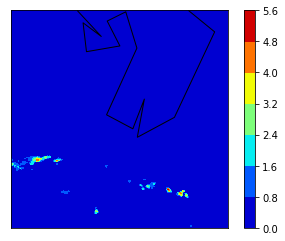

In [22]:
m = Basemap(llcrnrlat=lats_city.min(),urcrnrlat=lats_city.max(), \
                    llcrnrlon=lons_city.min(),urcrnrlon=lons_city.max())  # 描画矩形座標を指定
m.drawcoastlines()  # 海岸線
m.contourf(flat_lons_city, flat_lats_city, intensity_city,latlon=True, tri=True, cmap=mycmap) 

plt.colorbar()
plt.show()